In [ ]:
!pip uninstall --yes --quiet tensorflow
!pip install --quiet tensorflow==2.12.0
# Note that we install this version of TensorFlow since they removed KerasRegressor in 2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 44.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
# SciKit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
# TensorFlow
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor # Note that since TensorFlow 2.13.0, we should use the scikeras package instead.
rng_seed = 42

TensorFlow version:  2.12.0


<h1><center>Restaurant Review Prediction</center></h1>


<h1><center>1. Preprocessing</center></h1>



## 1.1 Loading data into panda frame

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving restaurant_reviews.csv to restaurant_reviews (1).csv


In [ ]:
data = pd.read_csv('restaurant_reviews.csv')
data

,Customer_ID,Restaurant_ID,Restaurant_Name,City,State,Date,Rating,Quality_of_Food,Rapidity_of_Serving,Taste,Ambiance,Service
0,2694,6722,"Mclean, Day and Heath",Wadestad,Colorado,2022-07-25,3.2,1.0,4.6,5.0,3.7,4.5
1,1461,8665,Gallagher Ltd,South Michelle,Kentucky,2022-05-18,2.6,1.8,1.1,1.8,2.2,1.5
2,6018,4131,Soto-Allison,South Matthew,New Jersey,2022-05-13,3.6,3.7,2.6,2.1,3.6,2.5
3,1032,8539,Alexander-Price,South Matthew,New Jersey,2022-09-11,3.0,4.8,3.5,5.0,3.7,4.2
4,4283,3944,Duarte-Haynes,New Michelle,Texas,2022-07-14,2.7,0.1,4.7,4.3,2.9,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2167,8499,1004,"Lynch, Lawrence and Pitts",North Lauraburgh,Vermont,2022-11-16,2.6,4.1,3.5,4.2,2.5,4.5
2168,1771,2493,Soto-Allison,Andrewview,Ohio,2022-04-05,2.2,0.7,4.8,1.9,3.6,4.6
2169,1272,6433,Pham Inc,Port Brianville,South Carolina,2022-09-20,2.2,1.1,1.4,1.1,1.5,1.2
2170,1745,9062,Mccullough LLC,South Sarahhaven,Virginia,2022-02-04,4.5,2.8,3.5,3.9,2.5,2.7


## 1.2 Inspecting columns and cleaning data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_ID          2172 non-null   int64  
 1   Restaurant_ID        2172 non-null   int64  
 2   Restaurant_Name      2172 non-null   object 
 3   City                 2172 non-null   object 
 4   State                2172 non-null   object 
 5   Date                 2172 non-null   object 
 6   Rating               2172 non-null   float64
 7   Quality_of_Food      2172 non-null   float64
 8   Rapidity_of_Serving  2172 non-null   float64
 9   Taste                2172 non-null   float64
 10  Ambiance             2172 non-null   float64
 11  Service              2172 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 203.8+ KB


In [ ]:
data = data.dropna()


## 1.3 Checking for correlations
We are going to look at the correlations between each feature and the target variable.

Customer_ID           -0.025962
Restaurant_ID          0.013325
Restaurant_Name       -0.013308
City                  -0.015690
State                 -0.014538
Date                  -0.025650
Rating                 1.000000
Quality_of_Food        0.417991
Rapidity_of_Serving   -0.306309
Taste                  0.257523
Ambiance               0.026035
Service               -0.393166
Name: Rating, dtype: float64


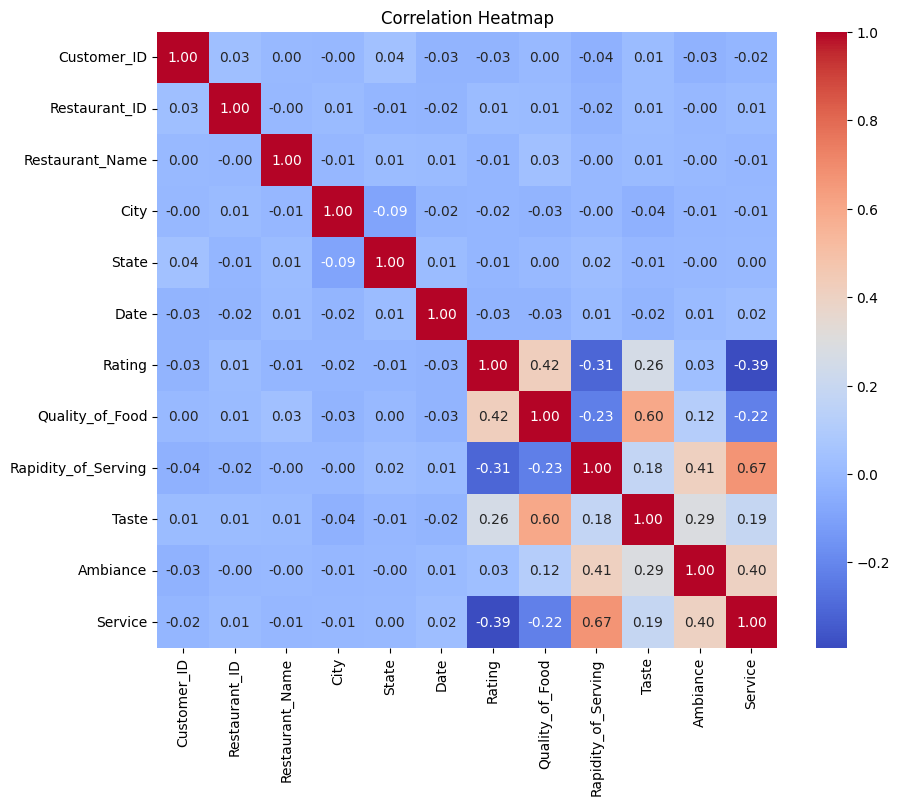

In [ ]:
data_encoded = data.copy()  # Create a copy of the original data

# Iterate through non-numeric columns and encode them
for column in data_encoded.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

# Calculate correlation matrix
correlation_matrix = data_encoded.corr()

# Display correlation values for the target variable 'Rating'
print(correlation_matrix['Rating'])

# Plotting a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

We can drop columns 'Customer_ID', 'Restaurant_ID', 'Restaurant_Name', 'City', 'State' and 'Date' to have more precise predictions

In [ ]:
data.drop(['Customer_ID', 'Restaurant_ID', 'Restaurant_Name', 'City', 'State', 'Date'],inplace=True,axis=1)

In [ ]:
# Separate features and target variable
X = data.drop('Rating', axis=1)
y = data['Rating']

# Split data into train and test sets using the selected columns
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=rng_seed)

<h1><center>2. Simple Linear Regression</center></h1>


## 2.1 Linear Regression Analysis
+ Data Centering
+ Linear Regression Parameter Estimation and Prediction

In [ ]:
Xlin = data.drop('Rating', axis=1).values
ylin = data['Rating'].values

# Center Inputs
muhatX = Xlin.mean(axis=0)
Xc = Xlin - muhatX

# Center Outputs
muhatY = ylin.mean(axis=0)
Yc = ylin - muhatY

In [ ]:
N = Xlin.shape[0]
P = Xlin.shape[1]

# The inverse input covariance matrix
invCovX = np.linalg.inv(Xc.T @ Xc)

# The least squares estimates of the parameters
theta1hat = invCovX @ Xc.T @ Yc
theta0hat = muhatY - muhatX @ theta1hat

# The prediction for each sample
Yhat = np.ones(N) * theta0hat + X @ theta1hat
Yhat

0       2.847323
1       3.322680
2       3.354187
3       3.309008
4       2.569514
          ...   
2167    2.910105
2168    2.403323
2169    3.135974
2170    3.220088
2171    3.708567
Length: 2172, dtype: float64

In [ ]:
R2 = 1 - np.sum((ylin - Yhat) ** 2) / np.sum((ylin - muhatY) ** 2)
print(R2)

0.3091999841798867


## 2.3 Hypothesis test
This step is to find features that are significant and to eliminate those that are not.

In [ ]:
sigmahat2 = 1 / (N - P - 1) * np.sum((ylin - Yhat) ** 2)
var_thetahat = np.diag(sigmahat2 * invCovX)
Z = theta1hat / np.sqrt(var_thetahat)
sigmahat2 = 1 / (N - P - 1) * np.sum((ylin - Yhat) ** 2)
p = 2 * (1 - stats.norm().cdf(np.abs(Z)))

ind_important = p<0.05
ind_important

array([ True,  True,  True,  True,  True])

## 2.4 Creating Linear Regression Model

In [ ]:
# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(Xtrain, ytrain)

# Make predictions on the test data
ypred = model.predict(Xtest)

MSE = mean_squared_error(ytest, ypred)
R2 = r2_score(ytest, ypred)
print("MSE: ", MSE)
print("R^2: ", R2)

MSE:  0.35060801525196883
R^2:  0.2994432647446513


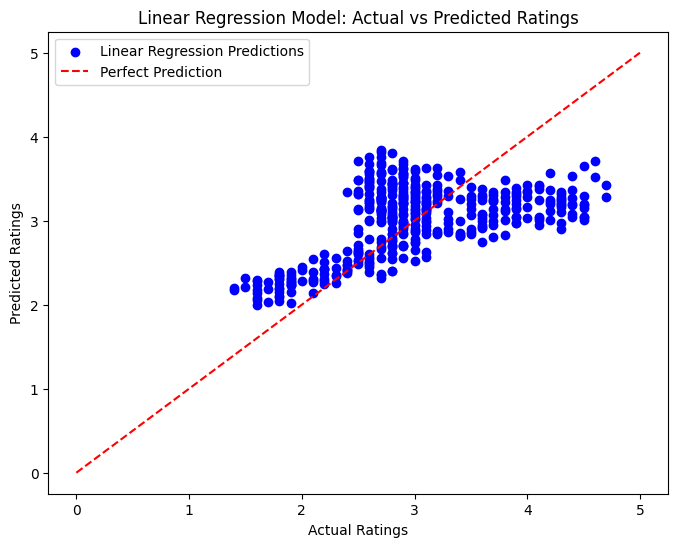

In [ ]:
# Plot of the actual vs predicted ratings for linear regression
plt.figure(figsize=(8, 6))
plt.scatter(ytest, ypred , color='blue', label='Linear Regression Predictions')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Linear Regression Model: Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame with actual and predicted ratings for Linear Regression
results_linear_regression = pd.DataFrame({'Actual Ratings': ytest, 'Predicted Ratings (Linear Regression)': ypred})

# Display a sample of the comparison DataFrame for Linear Regression
print("Comparison of Actual vs Predicted Ratings for the Linear Regression Model:\n")
print(results_linear_regression.head(10))  # Adjust the number as needed

Comparison of Actual vs Predicted Ratings for the Linear Regression Model:

      Actual Ratings  Predicted Ratings (Linear Regression)
1653             3.0                               3.061717
342              3.9                               2.969518
1343             2.7                               3.816791
765              2.9                               3.284147
865              2.7                               3.126318
259              2.6                               3.576578
736              2.6                               2.603167
2144             2.2                               2.608510
2095             2.8                               3.448271
387              2.9                               3.672624


<h1><center>3. Random Forest</center></h1>


## 3.1 Parameter tuning

In [ ]:
data

,Rating,Quality_of_Food,Rapidity_of_Serving,Taste,Ambiance,Service
0,3.2,1.0,4.6,5.0,3.7,4.5
1,2.6,1.8,1.1,1.8,2.2,1.5
2,3.6,3.7,2.6,2.1,3.6,2.5
3,3.0,4.8,3.5,5.0,3.7,4.2
4,2.7,0.1,4.7,4.3,2.9,4.5
...,...,...,...,...,...,...
2167,2.6,4.1,3.5,4.2,2.5,4.5
2168,2.2,0.7,4.8,1.9,3.6,4.6
2169,2.2,1.1,1.4,1.1,1.5,1.2
2170,4.5,2.8,3.5,3.9,2.5,2.7


In [ ]:
param_grid = {'n_estimators': [90, 100, 150],
              'max_depth': [None, 5, 10],
              'criterion': ["squared_error", "poisson"]
              }
base_estimator = RandomForestRegressor(random_state=rng_seed)
sh = GridSearchCV(base_estimator, param_grid)
sh.fit(Xtrain, ytrain)
print(sh.best_params_)
print(sh.best_score_)

{'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 100}
0.9883440985643345


In [ ]:
sh.cv_results_

{'mean_fit_time': array([0.92396784, 0.90940075, 1.74337893, 0.22141833, 0.30286074,
        0.72953625, 0.4485724 , 0.56419454, 0.89894052, 0.44694514,
        0.47235417, 1.00459909, 0.2333775 , 0.25977769, 0.51420503,
        0.37536492, 0.4176805 , 0.90880227]),
 'std_fit_time': array([0.07431356, 0.11957667, 0.58314904, 0.00428716, 0.12281974,
        0.17295374, 0.09013508, 0.01792753, 0.21592764, 0.04316191,
        0.00650187, 0.12023006, 0.0071582 , 0.0045091 , 0.24857596,
        0.00546513, 0.01058829, 0.11487013]),
 'mean_score_time': array([0.02734556, 0.02568641, 0.03399401, 0.00701423, 0.01636744,
        0.01776295, 0.01195502, 0.01538305, 0.02506242, 0.01042995,
        0.01230478, 0.02057462, 0.00798702, 0.00805688, 0.0103364 ,
        0.01078725, 0.01045418, 0.02125478]),
 'std_score_time': array([0.00970254, 0.01060735, 0.01396072, 0.00026967, 0.0179147 ,
        0.00525409, 0.00176821, 0.00270526, 0.00535424, 0.00011907,
        0.00175402, 0.00314537, 0.00148005, 

## 3.2 Creating Random Forest Regression Model

In [ ]:
# Create the Random Forest Regressor model
random_forest_model = RandomForestRegressor(n_estimators=100,criterion='squared_error', random_state=42)

# Fit the model to the training data
random_forest_model.fit(Xtrain, ytrain)

# Predict on the test data
ypred = random_forest_model.predict(Xtest)

# Evaluate the model
mse = mean_squared_error(ytest, ypred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.0681779955737901


In [ ]:
ytest.describe

<bound method NDFrame.describe of 1653    3.0
342     3.9
1343    2.7
765     2.9
865     2.7
       ... 
1337    3.4
1251    2.9
256     2.8
1473    2.4
1100    2.4
Name: Rating, Length: 435, dtype: float64>

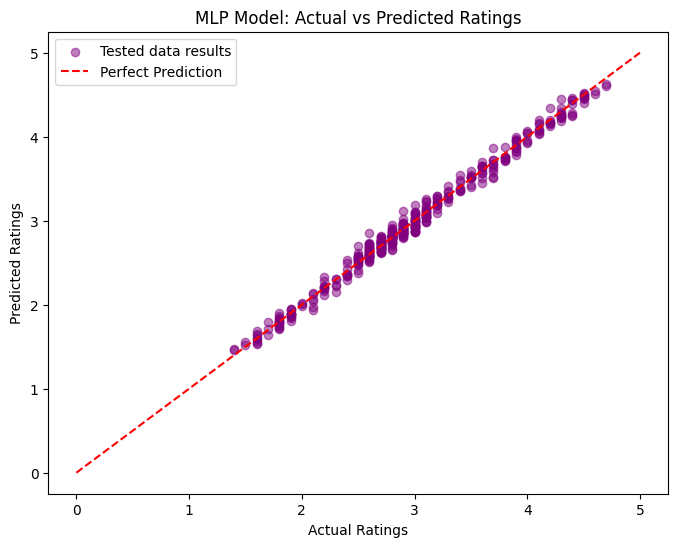

In [ ]:
# Scatter plot of Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(ytest, ypred, alpha=0.5, color='purple', label='Tested data results')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('MLP Model: Actual vs Predicted Ratings')
plt.legend()
plt.show()

## 3.3 Random Forest feature importances

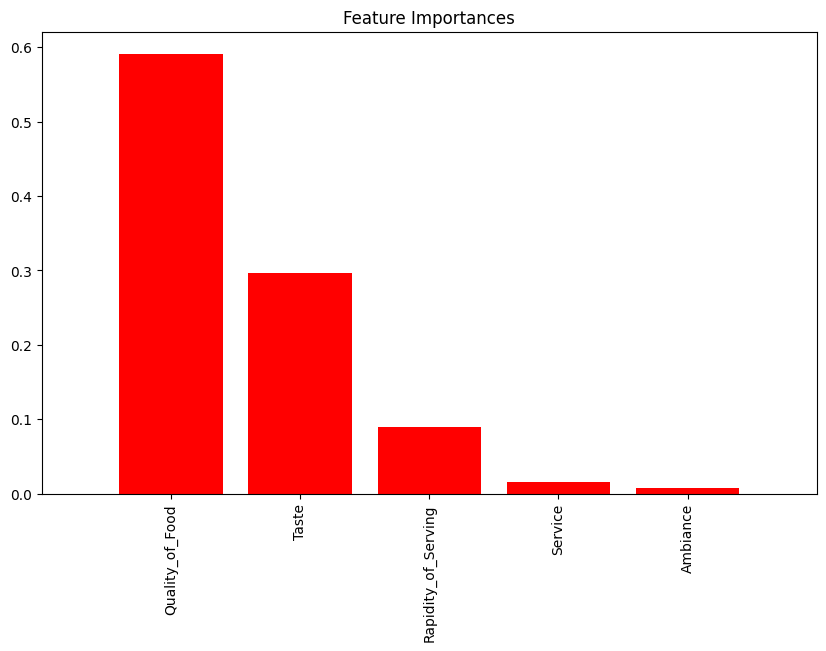

In [ ]:
# Get feature importances
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(Xtrain.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(Xtrain.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()


## 3.4 Single Tree

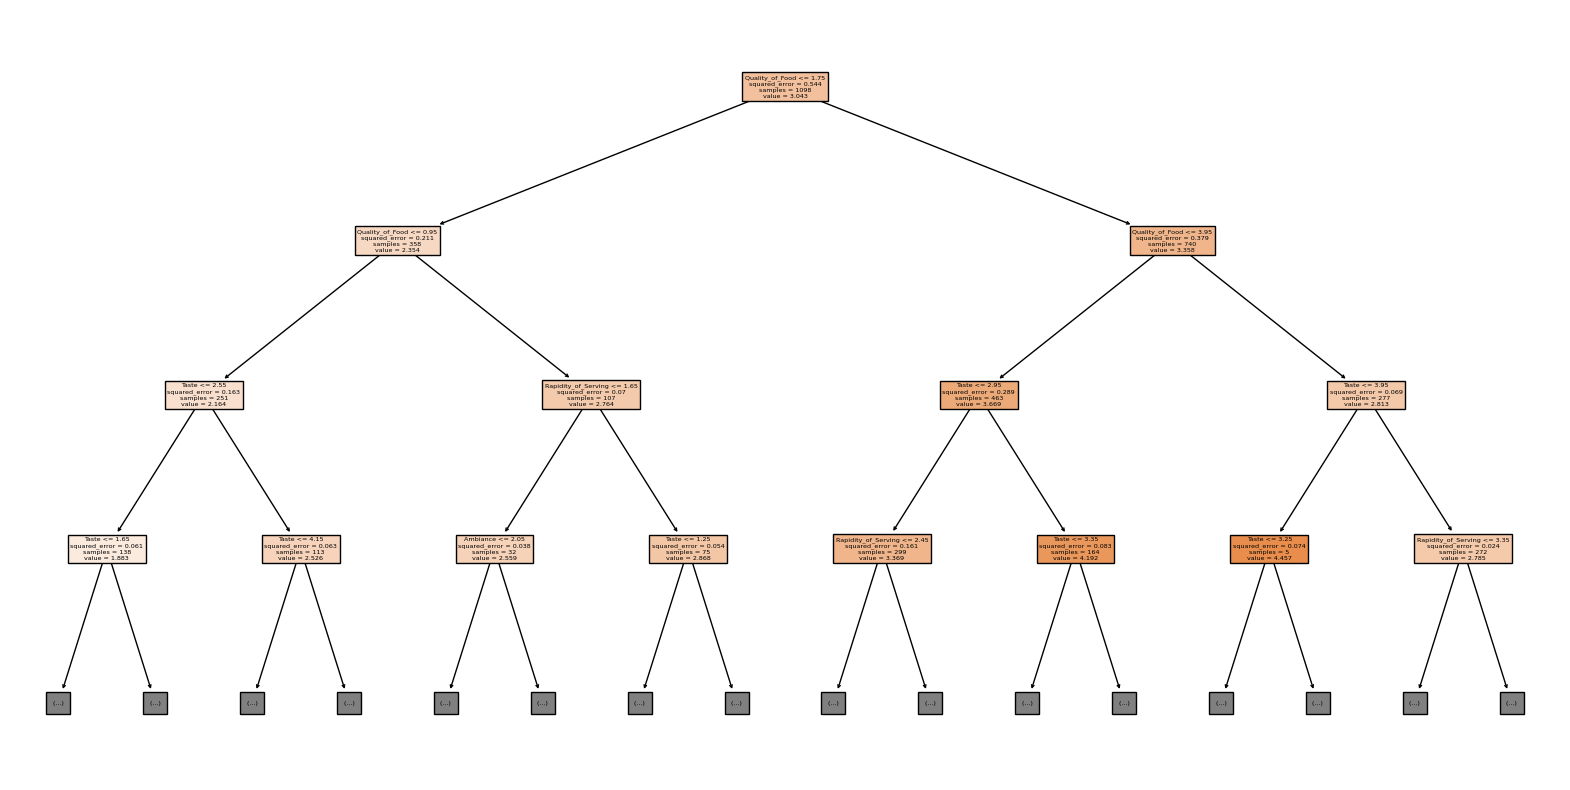

In [ ]:
single_tree = random_forest_model.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(single_tree, feature_names=Xtrain.columns, filled=True, max_depth=3)
plt.show()

<h1><center>4. Neural Network</center></h1>

## 4.1 Normalize the data

In [ ]:
scaler_X = StandardScaler()
Xtrain_scaled = scaler_X.fit_transform(Xtrain)
Xtest_scaled = scaler_X.transform(Xtest)

scaler_y = StandardScaler()
ytrain_scaled = scaler_y.fit_transform(ytrain.values.reshape(-1, 1)).flatten()
ytest_scaled = scaler_y.transform(ytest.values.reshape(-1, 1)).flatten()

## 4.2 Create the neural network model

#parameter tuning

In [ ]:
def create_model(hidden_layer_sizes=(100,), activation='relu', optimizer='adam'):
   model = Sequential()
   for layer_size in hidden_layer_sizes:
       model.add(Dense(layer_size, activation=activation))
   model.add(Dense(1))  # Output layer for regression
   model.compile(optimizer=optimizer, loss='mean_squared_error')
   return model


In [ ]:
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

parameter_space = {
    'hidden_layer_sizes': [(128, 64, 32), (100, 50)],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd'],
}
clf = GridSearchCV(estimator=model, param_grid=parameter_space, cv=5, n_jobs=-1)
clf.fit(Xtrain_scaled, ytrain_scaled)

<ipython-input-28-1588b91ecb7d>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7c3920719f60>,
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(128, 64, 32), (100, 50)],
                         'optimizer': ['adam', 'sgd']})

In [ ]:
print("Best parameters found: ", clf.best_params_)

Best parameters found:  {'activation': 'tanh', 'hidden_layer_sizes': (128, 64, 32), 'optimizer': 'adam'}


## 4.3 Train the model

In [ ]:
model = Sequential([
    Dense(128, activation='tanh', input_shape=(Xtrain_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(Xtrain_scaled, ytrain_scaled, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 1s 8ms/step - loss: 0.6641 - val_loss: 0.5049
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3906 - val_loss: 0.3377
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2961 - val_loss: 0.2591
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2388 - val_loss: 0.2221
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.2043 - val_loss: 0.1880
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1783 - val_loss: 0.1577
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1487 - val_loss: 0.1319
Epoch 8/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1291 - val_loss: 0.1189
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1200 - val_loss: 0.1028
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1038 - val_loss: 0.0942
Epoch 11/

## 4.4 Evaluate the model

In [ ]:
mse = model.evaluate(Xtest_scaled, ytest_scaled)
print(f"Test MSE: {mse}")

14/14 [==============================] - 0s 2ms/step - loss: 0.0070
Test MSE: 0.007008504122495651


14/14 [==============================] - 0s 2ms/step


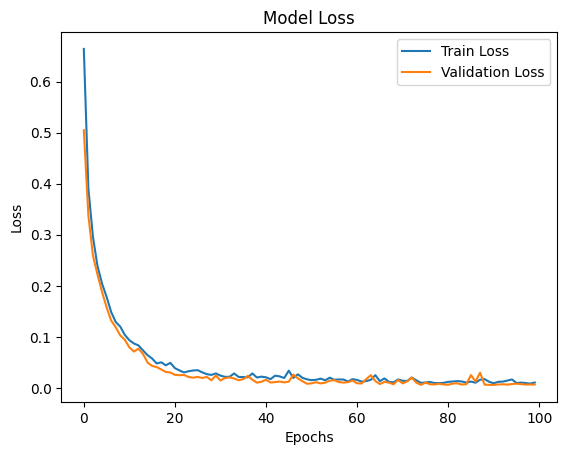

In [ ]:
y_pred_scaled = model.predict(Xtest_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

We can see that the loss decreases and converges rapidly. However, as expected, the more epochs we have, the more it converges

In [ ]:
ytest.describe

<bound method NDFrame.describe of 1653    3.0
342     3.9
1343    2.7
765     2.9
865     2.7
       ... 
1337    3.4
1251    2.9
256     2.8
1473    2.4
1100    2.4
Name: Rating, Length: 435, dtype: float64>

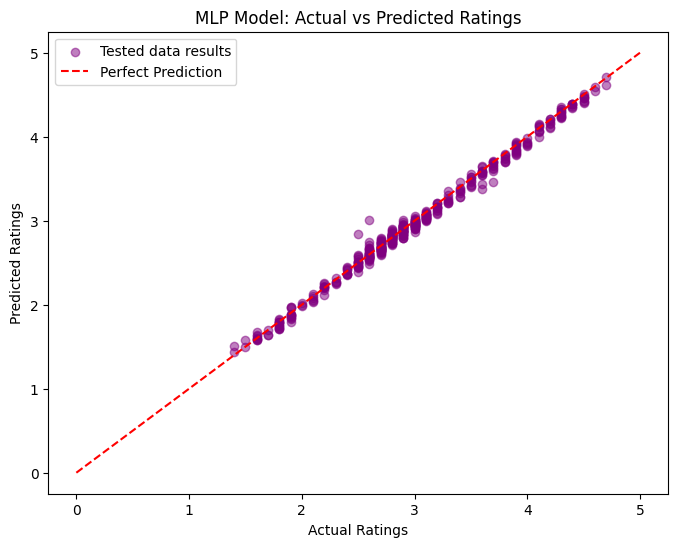

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, alpha=0.5, color='purple', label='Tested data results')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('MLP Model: Actual vs Predicted Ratings')
plt.legend()
plt.show()

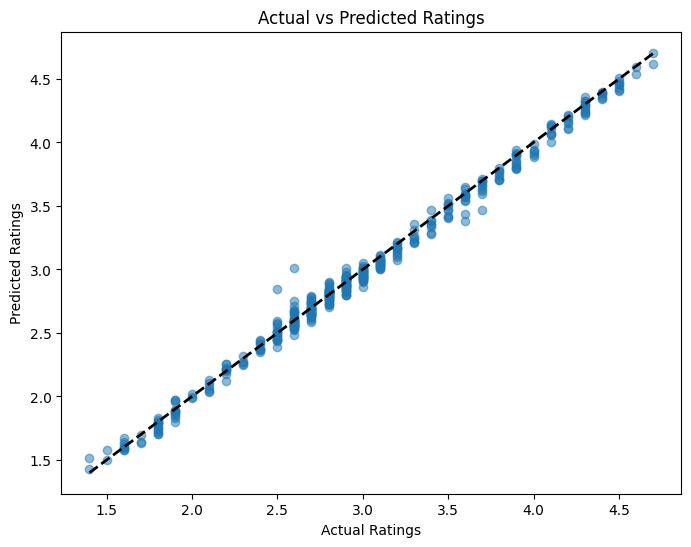

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=2)
plt.show()



We can see that all the results from the tested data are very close to the perfect prediction. Therefore the predicted ratings and the actual ratings are very close to each others. This suggests that the model has a good level of accuracy in predicting ratings.

In [ ]:
# Create DataFrames with actual and predicted ratings
results_mlp = pd.DataFrame({'Actual Ratings': ytest, 'Predicted Ratings ()': y_pred.ravel()})

# Display a sample of the comparison between actual and predicted ratings
print("Comparison of Actual vs Predicted Ratings (MLP):\n")
print(results_mlp.head(10))

Comparison of Actual vs Predicted Ratings (MLP):

      Actual Ratings  Predicted Ratings ()
1653             3.0              3.007026
342              3.9              3.845890
1343             2.7              2.698170
765              2.9              2.830142
865              2.7              2.630647
259              2.6              2.590233
736              2.6              2.610460
2144             2.2              2.205921
2095             2.8              2.832560
387              2.9              2.917679



The ratings both actual and predicted are within a similar range (around 2.2 to 3.9). This indicates that the model is consistent across this range and does not show extreme deviations.

In summary, your MLP model seems to perform well in predicting ratings, with predictions closely aligning with the actual values.

<h1><center>5. Adaboost</center></h1>

## 5.1 Train the model

In [ ]:
# Define parameter grid for AdaBoost
param_grid_adaboost = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Initialize AdaBoost model
adaboost = AdaBoostRegressor()

# Perform GridSearchCV for hyperparameter tuning
grid_search_adaboost = GridSearchCV(adaboost, param_grid=param_grid_adaboost, cv=5, scoring='neg_mean_squared_error')
grid_search_adaboost.fit(Xtrain, ytrain)

# Get the best parameters and best estimator
best_params_adaboost = grid_search_adaboost.best_params_
best_estimator_adaboost = grid_search_adaboost.best_estimator_

# Train the model with the best estimator
best_estimator_adaboost.fit(Xtrain, ytrain)

# Make predictions
y_pred_adaboost_tuned = best_estimator_adaboost.predict(Xtest)

# Evaluate the tuned model
mse_adaboost_tuned = mean_squared_error(ytest, y_pred_adaboost_tuned)
print(f"Tuned AdaBoost Mean Squared Error: {mse_adaboost_tuned}")

Tuned AdaBoost Mean Squared Error: 0.03130871104200004


## 5.2 Evaluate the model

AdaBoost - Mean Squared Error: 0.03130871104200004
AdaBoost - R-squared: 0.9374414518821715


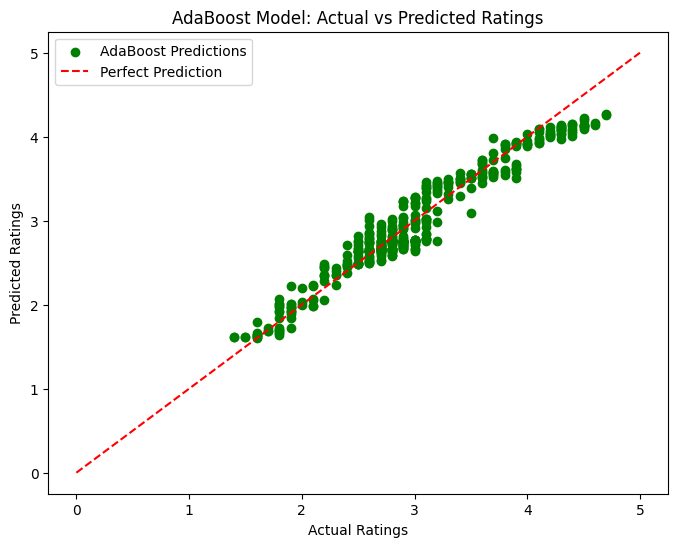

In [ ]:
# Using the trained AdaBoost model
predicted_ratings_adaboost = best_estimator_adaboost.predict(Xtest)

# Calculate evaluation metrics
mse_adaboost = mean_squared_error(ytest, predicted_ratings_adaboost)
r2_adaboost = r2_score(ytest, predicted_ratings_adaboost)
print(f"AdaBoost - Mean Squared Error: {mse_adaboost}")
print(f"AdaBoost - R-squared: {r2_adaboost}")

# Visualize the predictions vs actual ratings for AdaBoost
plt.figure(figsize=(8, 6))
plt.scatter(ytest, predicted_ratings_adaboost, color='green', label='AdaBoost Predictions')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('AdaBoost Model: Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [ ]:
results_adaboost = pd.DataFrame({'Actual Ratings': ytest, 'Predicted Ratings (AdaBoost)': predicted_ratings_adaboost})
# Display a sample of the comparison between actual and predicted ratings for AdaBoost
print("\nComparison of Actual vs Predicted Ratings (AdaBoost):\n")
print(results_adaboost.head(10))


Comparison of Actual vs Predicted Ratings (AdaBoost):

      Actual Ratings  Predicted Ratings (AdaBoost)
1653             3.0                      3.063864
342              3.9                      3.612069
1343             2.7                      2.645192
765              2.9                      2.922938
865              2.7                      2.837500
259              2.6                      2.642308
736              2.6                      2.520183
2144             2.2                      2.352137
2095             2.8                      2.745909
387              2.9                      2.751273


<h1><center>6. Gradient Boosted Tree</center></h1>

## 6.1 Train the model

In [ ]:
# Define parameter grid for Gradient Boosted Trees
param_grid_gb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

# Initialize Gradient Boosted Trees model
gb = GradientBoostingRegressor()

# Perform GridSearchCV for hyperparameter tuning
grid_search_gb = GridSearchCV(gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(Xtrain, ytrain)

# Get the best parameters and best estimator
best_params_gb = grid_search_gb.best_params_
best_estimator_gb = grid_search_gb.best_estimator_

# Train the model with the best estimator
best_estimator_gb.fit(Xtrain, ytrain)

# Make predictions
y_pred_gb_tuned = best_estimator_gb.predict(Xtest)

# Evaluate the tuned model
accuracy_gb_tuned = mean_squared_error(ytest, y_pred_gb_tuned)
print(f"Tuned Gradient Boosted Trees Accuracy: {accuracy_gb_tuned}")

Tuned Gradient Boosted Trees Accuracy: 0.0033011994731533185


## 6.2 Evaluate the model

Gradient Boosted Trees - Mean Squared Error: 0.0033011994731533185
Gradient Boosted Trees - R-squared: 0.9934038087415744


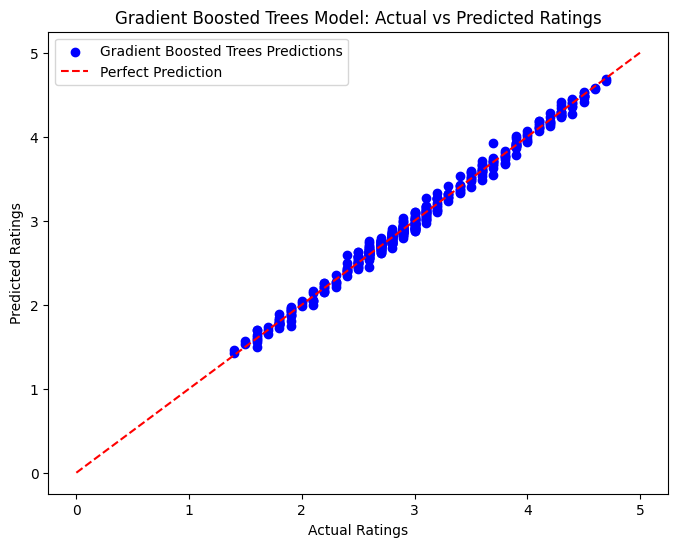

In [ ]:
# Using the trained Gradient Boosted Trees model
predicted_ratings_gb = best_estimator_gb.predict(Xtest)

# Calculate evaluation metrics
mse_gb = mean_squared_error(ytest, predicted_ratings_gb)
r2_gb = r2_score(ytest, predicted_ratings_gb)
print(f"Gradient Boosted Trees - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosted Trees - R-squared: {r2_gb}")

# Visualize the predictions vs actual ratings
plt.figure(figsize=(8, 6))
plt.scatter(ytest, predicted_ratings_gb, color='blue', label='Gradient Boosted Trees Predictions')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Gradient Boosted Trees Model: Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [ ]:
# Create DataFrames with actual and predicted ratings
results_gb = pd.DataFrame({'Actual Ratings': ytest, 'Predicted Ratings (Gradient Boosted Trees)': predicted_ratings_gb})

# Display a sample of the comparison between actual and predicted ratings
print("Comparison of Actual vs Predicted Ratings (Gradient Boosted Trees):\n")
print(results_gb.head(10))

Comparison of Actual vs Predicted Ratings (Gradient Boosted Trees):

      Actual Ratings  Predicted Ratings (Gradient Boosted Trees)
1653             3.0                                    3.107667
342              3.9                                    3.908032
1343             2.7                                    2.694192
765              2.9                                    2.874764
865              2.7                                    2.690324
259              2.6                                    2.596575
736              2.6                                    2.555121
2144             2.2                                    2.186065
2095             2.8                                    2.836060
387              2.9                                    2.855622
